<div class="alert alert-danger">
    <h4 style="font-weight: bold; font-size: 28px;">ARIMAX with Box Score Features</h4>
    <h5 style="font-weight: bold; font-size: 24px;">Test Set using Expanding Window</h5>
    <p style="font-size: 20px;">NBA API Seasons 2021-22 to 2023-24</p>
</div>

<a name="Models"></a>

# Setup

[Return to top](#Models)

In [1]:
import sys
from pathlib import Path
# get current working directory
cwd = %pwd
# add shared_code directory to Python sys.path
sys.path.append(str(Path(cwd).parent / "shared_code"))
# import all libraries in shared_code directory 'imports.py' file
from imports import *
%matplotlib inline

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.graphics.api as smg
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.gofplots import qqplot
from scipy.signal import periodogram

import pmdarima as pm
from pmdarima.model_selection import train_test_split as pm_train_test_split
from pmdarima.model_selection import RollingForecastCV
from pmdarima.metrics import smape 
from pmdarima.utils import tsdisplay
from pmdarima.preprocessing import BoxCoxEndogTransformer
from arch import arch_model

from sklearn import neighbors, decomposition, metrics, preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn import metrics

# Data

[Return to top](#Models)

Data splits:

- Define NBA Season 2021-22 as the TRAINING set: regular season is 2021-10-19 to 2022-04-10. 
- Define NBA Season 2022-23 as the VALIDATION set: regular season is 2022-10-18 to 2023-04-09.
- Define NBA Season 2023-24 as the TESTING set: regular season is 2023-10-24 to 2024-04-14.

In [3]:
# load, filter (by time) and scale data
pts_scaled_df, pm_scaled_df, res_scaled_df, test_set_obs = utl.load_and_scale_data(
    file_path='../../data/processed/nba_team_matchups_rolling_box_scores_2022_2024_r05.csv',
    seasons_to_keep=['2021-22', '2022-23', '2023-24'], 
    training_season='2021-22',
    feature_prefix='ROLL_',
    scaler_type='minmax', 
    scale_target=False
)

Season 2021-22: 1186 games
Season 2022-23: 1181 games
Season 2023-24: 692 games
Total number of games across sampled seasons: 3059 games


In [22]:
# define number of games in seasons
season_22_ngames = 1186
season_23_ngames = 1181

In [4]:
pts_scaled_df.head()

,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,TOTAL_PTS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,124.0,42.0,87.0,0.483,16.0,38.0,0.421,24.0,31.0,0.774,13.0,33.0,46.0,26.0,18.0,12.0,18.0,22.0,112.0,42.0,87.0,0.483,15.0,29.0,0.517,13.0,16.0,0.813,9.0,33.0,42.0,26.0,7.0,5.0,16.0,20.0,185
2021-10-23,83.0,30.0,97.0,0.309,7.0,34.0,0.206,16.0,22.0,0.727,19.0,35.0,54.0,14.0,10.0,4.0,19.0,21.0,87.0,31.0,93.0,0.333,13.0,43.0,0.302,12.0,13.0,0.923,10.0,40.0,50.0,16.0,7.0,3.0,15.0,21.0,198
2021-10-23,121.0,45.0,93.0,0.484,12.0,35.0,0.343,19.0,22.0,0.864,9.0,40.0,49.0,25.0,5.0,5.0,12.0,22.0,115.0,42.0,86.0,0.488,10.0,32.0,0.313,21.0,28.0,0.750,7.0,40.0,47.0,31.0,8.0,2.0,11.0,22.0,239
2021-10-23,123.0,49.0,98.0,0.500,13.0,30.0,0.433,12.0,18.0,0.667,13.0,30.0,43.0,32.0,8.0,3.0,8.0,22.0,95.0,32.0,84.0,0.381,12.0,42.0,0.286,19.0,29.0,0.655,5.0,33.0,38.0,19.0,6.0,0.0,15.0,26.0,232
2021-10-24,124.0,48.0,95.0,0.505,17.0,38.0,0.447,11.0,14.0,0.786,10.0,44.0,54.0,29.0,12.0,10.0,17.0,18.0,134.0,48.0,117.0,0.410,21.0,57.0,0.368,17.0,23.0,0.739,15.0,41.0,56.0,34.0,13.0,9.0,18.0,24.0,204


In [5]:
pm_scaled_df.head()

,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,PLUS_MINUS
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,124.0,42.0,87.0,0.483,16.0,38.0,0.421,24.0,31.0,0.774,13.0,33.0,46.0,26.0,18.0,12.0,18.0,22.0,112.0,42.0,87.0,0.483,15.0,29.0,0.517,13.0,16.0,0.813,9.0,33.0,42.0,26.0,7.0,5.0,16.0,20.0,7.0
2021-10-23,83.0,30.0,97.0,0.309,7.0,34.0,0.206,16.0,22.0,0.727,19.0,35.0,54.0,14.0,10.0,4.0,19.0,21.0,87.0,31.0,93.0,0.333,13.0,43.0,0.302,12.0,13.0,0.923,10.0,40.0,50.0,16.0,7.0,3.0,15.0,21.0,-8.0
2021-10-23,121.0,45.0,93.0,0.484,12.0,35.0,0.343,19.0,22.0,0.864,9.0,40.0,49.0,25.0,5.0,5.0,12.0,22.0,115.0,42.0,86.0,0.488,10.0,32.0,0.313,21.0,28.0,0.750,7.0,40.0,47.0,31.0,8.0,2.0,11.0,22.0,29.0
2021-10-23,123.0,49.0,98.0,0.500,13.0,30.0,0.433,12.0,18.0,0.667,13.0,30.0,43.0,32.0,8.0,3.0,8.0,22.0,95.0,32.0,84.0,0.381,12.0,42.0,0.286,19.0,29.0,0.655,5.0,33.0,38.0,19.0,6.0,0.0,15.0,26.0,-10.0
2021-10-24,124.0,48.0,95.0,0.505,17.0,38.0,0.447,11.0,14.0,0.786,10.0,44.0,54.0,29.0,12.0,10.0,17.0,18.0,134.0,48.0,117.0,0.410,21.0,57.0,0.368,17.0,23.0,0.739,15.0,41.0,56.0,34.0,13.0,9.0,18.0,24.0,-10.0


In [6]:
res_scaled_df.head()

,ROLL_HOME_PTS,ROLL_HOME_FGM,ROLL_HOME_FGA,ROLL_HOME_FG_PCT,ROLL_HOME_FG3M,ROLL_HOME_FG3A,ROLL_HOME_FG3_PCT,ROLL_HOME_FTM,ROLL_HOME_FTA,ROLL_HOME_FT_PCT,ROLL_HOME_OREB,ROLL_HOME_DREB,ROLL_HOME_REB,ROLL_HOME_AST,ROLL_HOME_STL,ROLL_HOME_BLK,ROLL_HOME_TOV,ROLL_HOME_PF,ROLL_AWAY_PTS,ROLL_AWAY_FGM,ROLL_AWAY_FGA,ROLL_AWAY_FG_PCT,ROLL_AWAY_FG3M,ROLL_AWAY_FG3A,ROLL_AWAY_FG3_PCT,ROLL_AWAY_FTM,ROLL_AWAY_FTA,ROLL_AWAY_FT_PCT,ROLL_AWAY_OREB,ROLL_AWAY_DREB,ROLL_AWAY_REB,ROLL_AWAY_AST,ROLL_AWAY_STL,ROLL_AWAY_BLK,ROLL_AWAY_TOV,ROLL_AWAY_PF,GAME_RESULT
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-23,124.0,42.0,87.0,0.483,16.0,38.0,0.421,24.0,31.0,0.774,13.0,33.0,46.0,26.0,18.0,12.0,18.0,22.0,112.0,42.0,87.0,0.483,15.0,29.0,0.517,13.0,16.0,0.813,9.0,33.0,42.0,26.0,7.0,5.0,16.0,20.0,1
2021-10-23,83.0,30.0,97.0,0.309,7.0,34.0,0.206,16.0,22.0,0.727,19.0,35.0,54.0,14.0,10.0,4.0,19.0,21.0,87.0,31.0,93.0,0.333,13.0,43.0,0.302,12.0,13.0,0.923,10.0,40.0,50.0,16.0,7.0,3.0,15.0,21.0,0
2021-10-23,121.0,45.0,93.0,0.484,12.0,35.0,0.343,19.0,22.0,0.864,9.0,40.0,49.0,25.0,5.0,5.0,12.0,22.0,115.0,42.0,86.0,0.488,10.0,32.0,0.313,21.0,28.0,0.750,7.0,40.0,47.0,31.0,8.0,2.0,11.0,22.0,1
2021-10-23,123.0,49.0,98.0,0.500,13.0,30.0,0.433,12.0,18.0,0.667,13.0,30.0,43.0,32.0,8.0,3.0,8.0,22.0,95.0,32.0,84.0,0.381,12.0,42.0,0.286,19.0,29.0,0.655,5.0,33.0,38.0,19.0,6.0,0.0,15.0,26.0,0
2021-10-24,124.0,48.0,95.0,0.505,17.0,38.0,0.447,11.0,14.0,0.786,10.0,44.0,54.0,29.0,12.0,10.0,17.0,18.0,134.0,48.0,117.0,0.410,21.0,57.0,0.368,17.0,23.0,0.739,15.0,41.0,56.0,34.0,13.0,9.0,18.0,24.0,0


# Stationarity

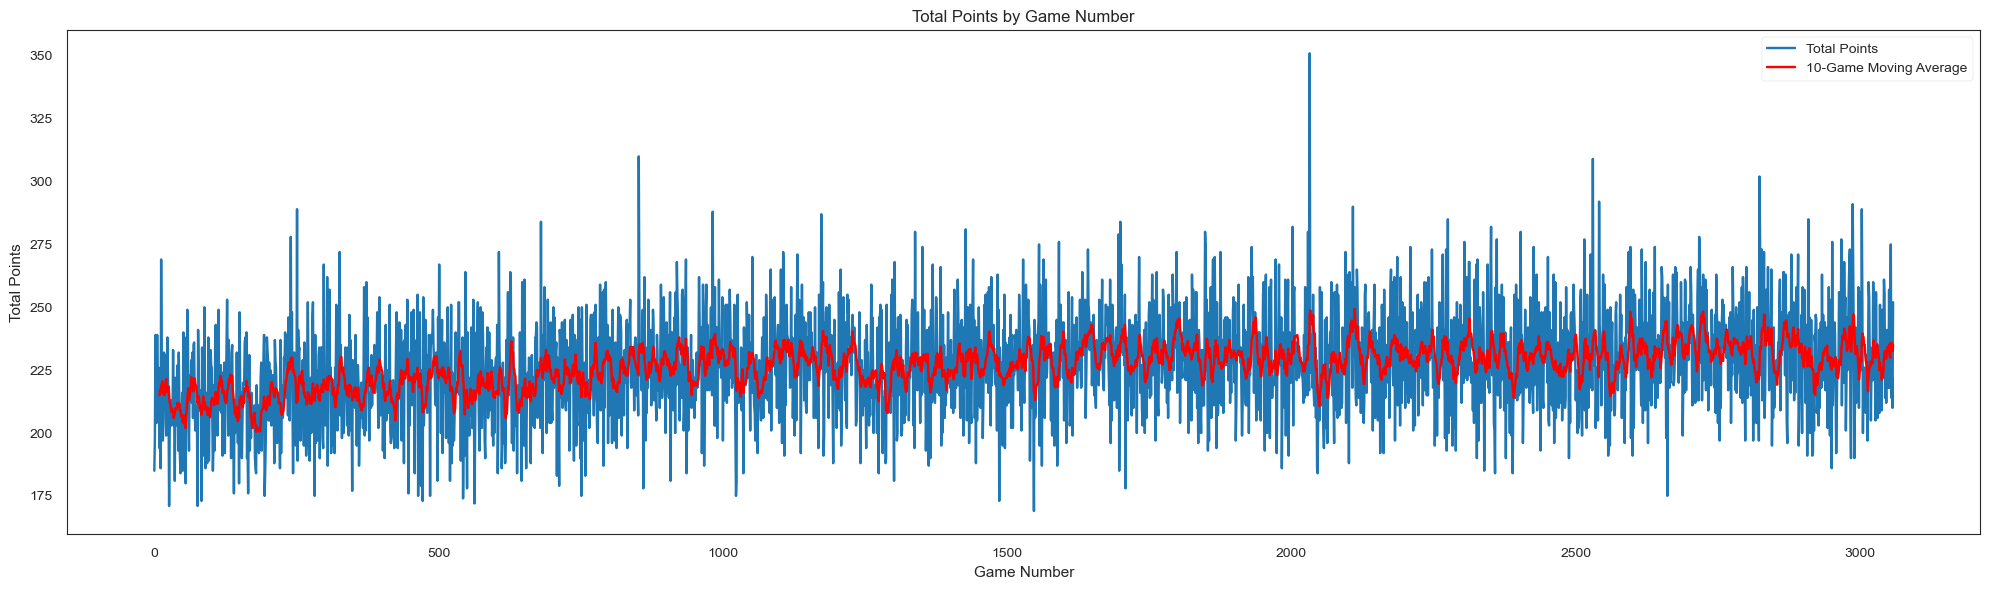

In [13]:
pts_scaled_df.reset_index(drop=True, inplace=True)

# n-game rolling average
ngame = 10

plt.figure(figsize=(20, 6))
plt.plot(pts_scaled_df.index, pts_scaled_df['TOTAL_PTS'], label='Total Points')
# calculate n-game rolling mean
rolling_mean = pts_scaled_df['TOTAL_PTS'].rolling(window=ngame).mean()
plt.plot(rolling_mean, color='red', label=f'{ngame}-Game Moving Average')
plt.title('Total Points by Game Number')
plt.xlabel('Game Number')
plt.ylabel('Total Points')
plt.legend()  
plt.tight_layout()
plt.show()

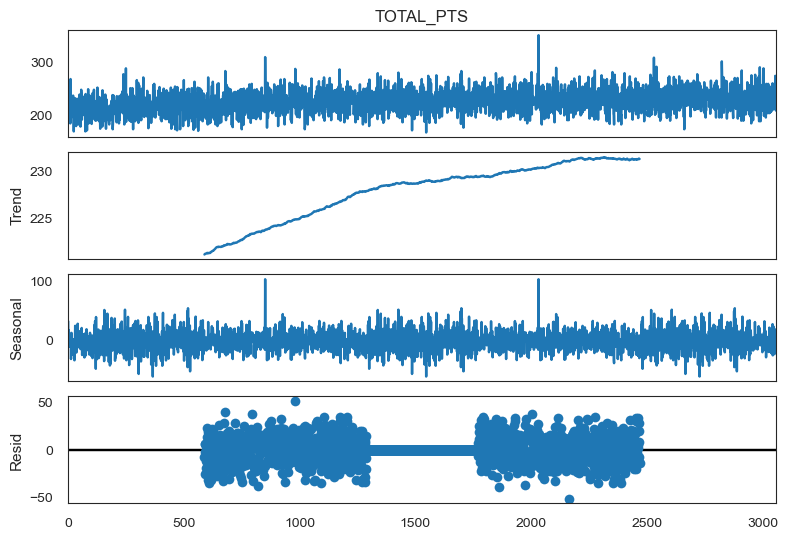

In [17]:
# series decomposition
decomp = seasonal_decompose(pts_scaled_df['TOTAL_PTS'], model='additive', period=1180)
decomp.plot();

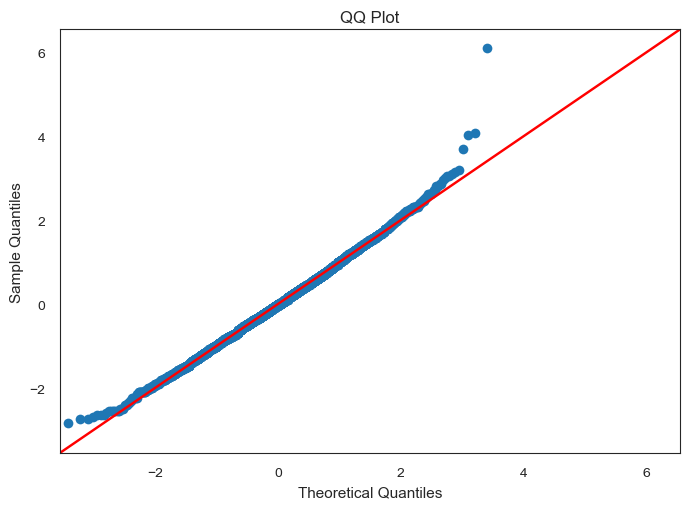

In [18]:
# QQplot
sm.qqplot(pts_scaled_df['TOTAL_PTS'], fit=True, line="45");
plt.title('QQ Plot');

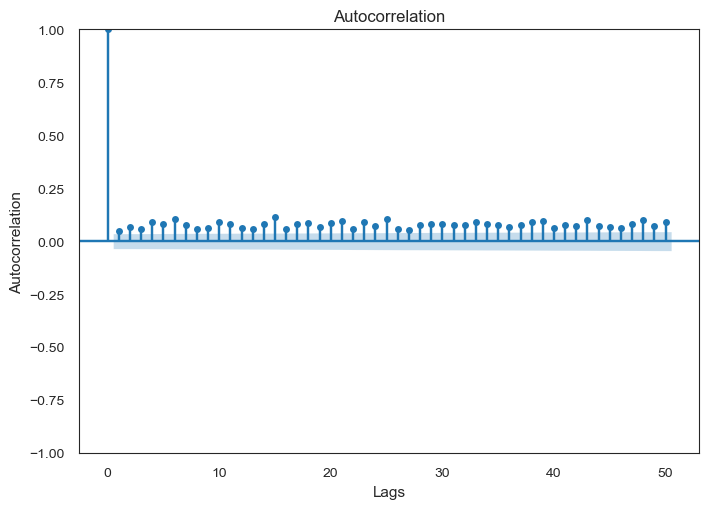

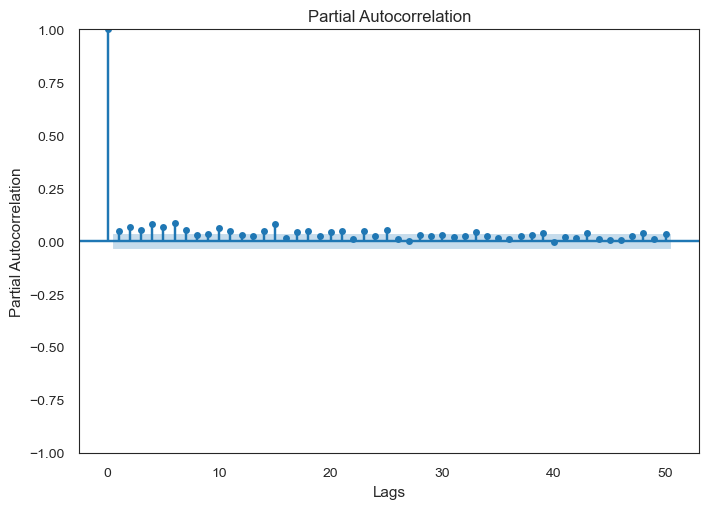

In [19]:
# plot autocorrelation and partial autocorrelation of the series
plot_acf(pts_scaled_df['TOTAL_PTS'], lags=50);
plt.xlabel('Lags')
plt.ylabel('Autocorrelation');

plot_pacf(pts_scaled_df['TOTAL_PTS'], lags=50);
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation');

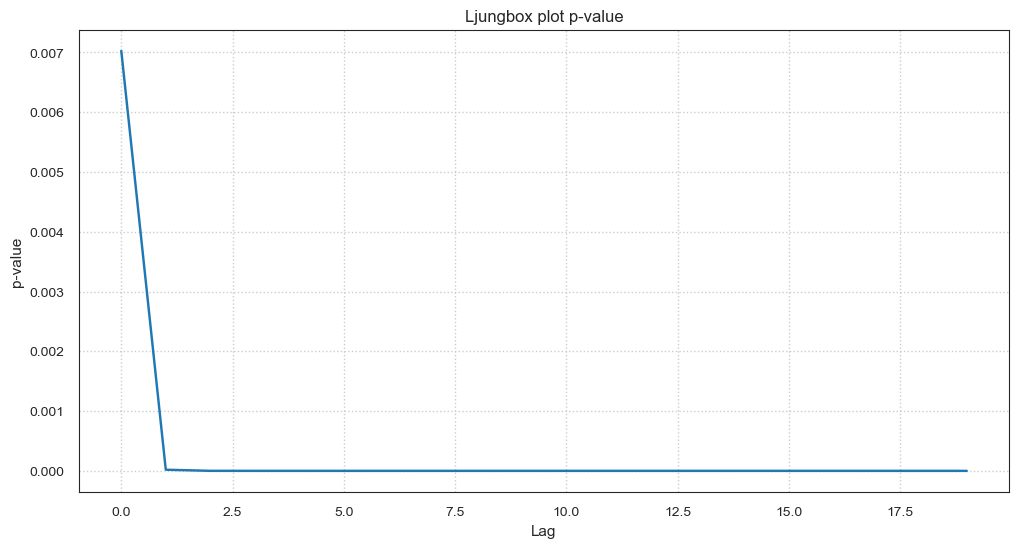

In [20]:
# Ljungbox plot
lj_df = sm.stats.acorr_ljungbox(pts_scaled_df['TOTAL_PTS'], lags=20, return_df=True)

# plot of time series
fig, ax = plt.subplots(figsize=(12,6))

x_axis = np.arange(lj_df.shape[0])
plt.plot(x_axis, lj_df.lb_pvalue);

ax.grid(linestyle='dotted')
ax.set(title = 'Ljungbox plot p-value', 
       xlabel = 'Lag', 
       ylabel = 'p-value');

In [21]:
print("Are the data stationary?")
dftest = adfuller(pts_scaled_df['TOTAL_PTS'], autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

Are the data stationary?
Test statistic = -5.745
P-value = 0.000
Critical values :
	1%: -3.4325071658732287 - The data is  stationary with 99% confidence
	5%: -2.8624930981764027 - The data is  stationary with 95% confidence
	10%: -2.5672773585499256 - The data is  stationary with 90% confidence


# SARIMA

## Model

In [ ]:
# split the data
y_train, y_test = pm_train_test_split(pts_scaled_df['TOTAL_PTS'], train_size=season_22_ngames+season_23_ngames)

In [ ]:
# fit models
model1 = pm.auto_arima(
    y_train, 
    start_p=1, start_q=1, start_P=1, start_Q=1,
    max_p=10,   max_q=10,   max_P=10,   max_Q=10,
    max_d=10,   max_D=10,
    max_order=None,
    seasonal=True,
    m=1180, # period for season differences
    stationary=False,
    information_criterion='aic',
    stepwise=True)

sarima_residuals = model1.resid()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


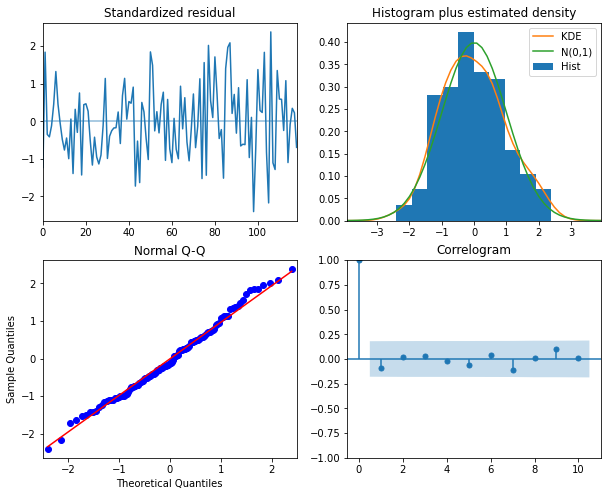

In [23]:
model1.plot_diagnostics();

## Stationarity of Residuals

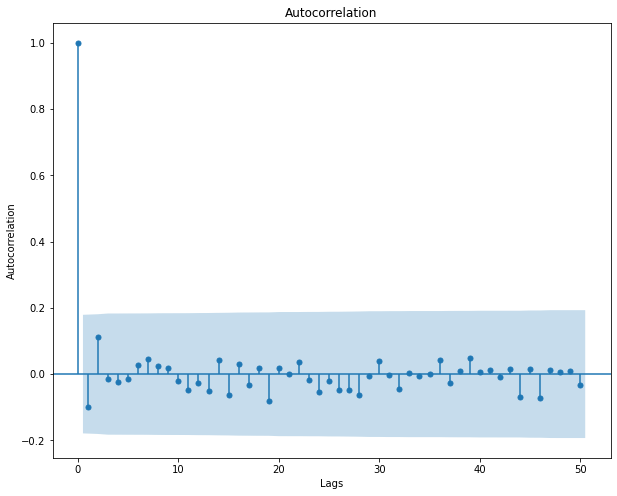

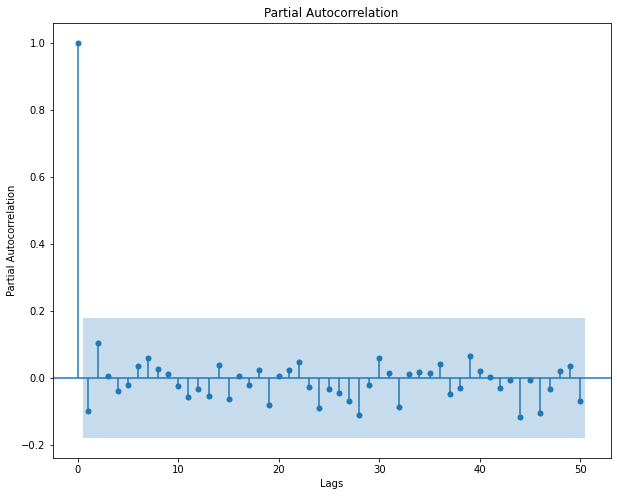

In [24]:
# plot autocorrelation and partial autocorrelation of the residuals of the series
plot_acf(sarima_residuals, lags=50);
plt.xlabel('Lags')
plt.ylabel('Autocorrelation');

plot_pacf(sarima_residuals, lags=50);
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation');

In [25]:
print("Are the model residuals stationary?")
dftest = adfuller(sarima_residuals, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

Are the model residuals stationary?
Test statistic = -26.100
P-value = 0.000
Critical values :
	1%: -3.4865346059036564 - The data is  stationary with 99% confidence
	5%: -2.8861509858476264 - The data is  stationary with 95% confidence
	10%: -2.579896092790057 - The data is  stationary with 90% confidence


**COMMENT: The p-value for the Dickey-Fuller test is <0.05, so we can reject the null hypothesis that the data are not stationary.**

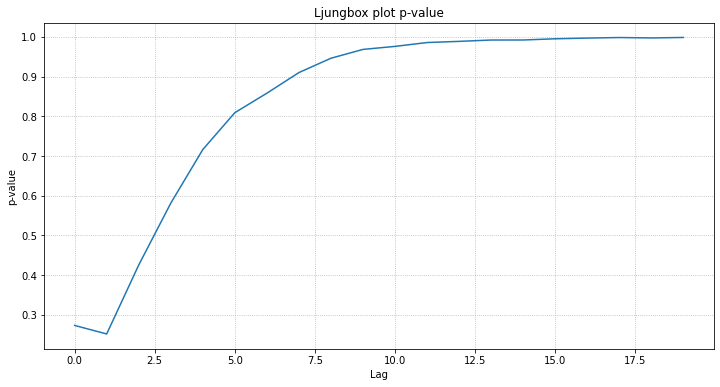

In [26]:
# Ljungbox test on model residuals

# Ljungbox plot
lj_df = sm.stats.acorr_ljungbox(sarima_residuals, lags=20, return_df=True)

# plot of time series
fig, ax = plt.subplots(figsize=(12,6))

x_axis = np.arange(lj_df.shape[0])
plt.plot(x_axis, lj_df.lb_pvalue);

ax.grid(linestyle='dotted')
ax.set(title = 'Ljungbox plot p-value', 
       xlabel = 'Lag', 
       ylabel = 'p-value');

In [27]:
# model summary
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -173.015
Date:                            Wed, 03 Nov 2021   AIC                            358.030
Time:                                    12:34:41   BIC                            374.705
Sample:                                         0   HQIC                           364.801
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.001      0.343      0.732      -0.002       0.002
ar.L1          0.2986      0.090      3.332      0.001       0.123       0.474
ma.L1         -0.9865      0.028    -35.577      0.000      -1.041      -0.932
ar.S.L12       0.9891      0.032     30.781      0.000       0.926       1.052
ma.S.L12      -0.8437      0.218     -3.877      0.000      -1.270      -0.417
sigma2         0.9632      0.182      5.282      0.000       0.606       1.321
===================================================================================
Ljung-Box (L1) (Q):                   1.10   Jarque-Bera (JB):                 1.49
Prob(Q):                              0.29   Prob(JB):                         0.47
Heteroskedasticity (H):               2.16   Skew:                             0.21
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
# forecast mean (mu) and CI 27 months into the future
mu_forecast, mu_conf_int = model1.predict(n_periods=y_test.shape[0], return_conf_int=True)

# SMAPE
print("Symmetric Mean Absolute Percentage Error:", round(smape(y_test, mu_forecast), 2), "%")

Symmetric Mean Absolute Percentage Error: 2.91 %


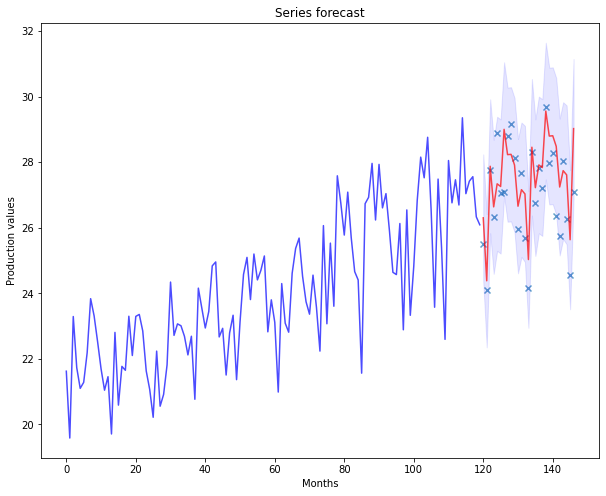

In [29]:
# plot forecast (blue=train, red=forecast)
x_axis = np.arange(time_df.production.shape[0])
plt.plot(x_axis[:y_train.shape[0]], y_train, c='blue', alpha=0.7)
plt.plot(x_axis[y_train.shape[0]:], mu_forecast, c='red', alpha=0.7) # forecast
plt.scatter(x_axis[y_train.shape[0]:], y_test, alpha=0.7, marker='x') # test data
plt.fill_between(x_axis[-mu_forecast.shape[0]:], mu_conf_int[:, 0], mu_conf_int[:, 1], 
                 alpha=0.1, color='blue')
plt.title('Series forecast')
plt.xlabel('Months')
plt.ylabel('Production values')
plt.show();

# GARCH

**COMMENT: So far, we've developed a SARIMA model for the conditional expectation of the series, but in that model the conditional variance is constant, which may not reflect reality if the series is volitile - and the plot of the residuals suggested that variance increased over time. We can create a model for the conditional variance using a GARCH (Generalized AutoRegressive Conditional Heteroskedasticity) model, by feeding into it the residuals from the SARIMA model.** 

Iteration:      1,   Func. Count:      6,   Neg. LLF: 10057132790.54468
Iteration:      2,   Func. Count:     13,   Neg. LLF: 39857817.76907745
Iteration:      3,   Func. Count:     19,   Neg. LLF: 421.5728491632153
Iteration:      4,   Func. Count:     25,   Neg. LLF: 483.0318377261866
Iteration:      5,   Func. Count:     31,   Neg. LLF: 186.9315057858655
Iteration:      6,   Func. Count:     36,   Neg. LLF: 186.55342318613174
Iteration:      7,   Func. Count:     41,   Neg. LLF: 186.5025565150487
Iteration:      8,   Func. Count:     46,   Neg. LLF: 186.4284760239896
Iteration:      9,   Func. Count:     51,   Neg. LLF: 186.3962924266263
Iteration:     10,   Func. Count:     56,   Neg. LLF: 186.38965131144647
Iteration:     11,   Func. Count:     61,   Neg. LLF: 186.3894092760159
Iteration:     12,   Func. Count:     66,   Neg. LLF: 186.3894084761753
Optimization terminated successfully    (Exit mode 0)
            Current function value: 186.3894084761753
            Iterations: 12

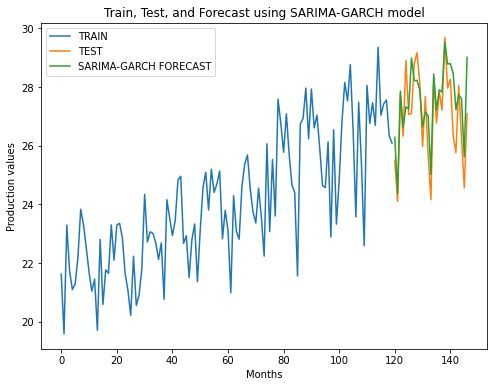

In [30]:
# fit a GARCH(1,1) model on the residuals of the SARIMA model
garch = arch_model(sarima_residuals, p=1, q=1)
model2 = garch.fit()

# predict residual using GARCH
resid_forecast = model2.forecast(horizon=y_test.shape[0]).mean.iloc[-1]
 
# combine both models' forecast: yt = mu (SARIMA) + resid (GARCH)
y_forecast_garch = mu_forecast + resid_forecast
y_forecast_garch.index = np.arange(120, 147)

# plot
y_train.plot(legend=True, label='TRAIN', figsize=(8,6))
y_test.plot(legend=True, label='TEST')
y_forecast_garch.plot(legend=True, label='SARIMA-GARCH FORECAST')
plt.xlabel('Months')
plt.ylabel('Production values')
plt.title('Train, Test, and Forecast using SARIMA-GARCH model')
plt.show();

In [31]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -186.389
Distribution:                  Normal   AIC:                           380.779
Method:            Maximum Likelihood   BIC:                           391.929
                                        No. Observations:                  120
Date:                Wed, Nov 03 2021   Df Residuals:                      119
Time:                        12:34:41   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0133  9.487e-02     -0.140      0.889 [ -0.199,  0.173]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.3329      0.103      3.242  1.188e-03      [  0.132,  0.534]
alpha[1]       0.0000  2.488e-02      0.000      1.000 [-4.877e-02,4.877e-02]
beta[1]        0.6615      0.101      6.580  4.711e-11      [  0.464,  0.859]
=============================================================================

Covariance estimator: robust
"""

# Holt-Winters

Symmetric Mean Absolute Percentage Error: 2.99 %


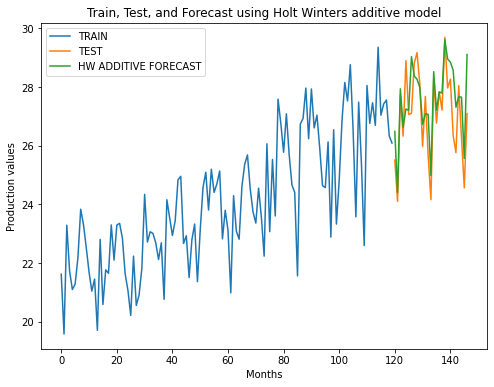

In [33]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

HW_ADD_model = ExponentialSmoothing(
    y_train,
    trend='add',
    seasonal='add', 
    seasonal_periods=12).fit()

y_forecast_HW_ADD = HW_ADD_model.forecast(y_test.shape[0]) # number of steps to forecast

# SMAPE
print("Symmetric Mean Absolute Percentage Error:", round(smape(y_test, y_forecast_HW_ADD), 2), "%")

# plot
y_train.plot(legend=True, label='TRAIN', figsize=(8,6))
y_test.plot(legend=True, label='TEST')
y_forecast_HW_ADD.plot(legend=True, label='HW ADDITIVE FORECAST')
plt.xlabel('Months')
plt.ylabel('Production values')
plt.title('Train, Test, and Forecast using Holt Winters additive model')
plt.show();

Symmetric Mean Absolute Percentage Error: 3.37 %


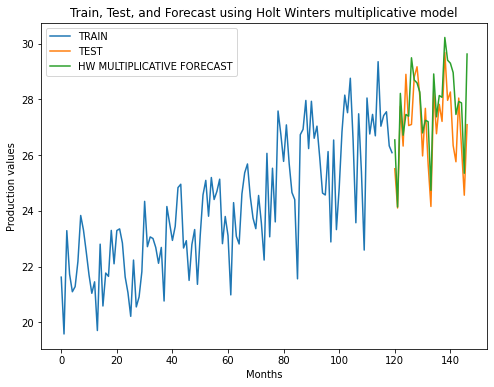

In [34]:
HW_MULT_model = ExponentialSmoothing(
    y_train/10,
    trend='mul',
    seasonal='mul', 
    seasonal_periods=12).fit()

y_forecast_HW_MULT = HW_MULT_model.forecast(y_test.shape[0])*10 # number of steps to forecast

# SMAPE
print("Symmetric Mean Absolute Percentage Error:", round(smape(y_test, y_forecast_HW_MULT), 2), "%")

# plot
y_train.plot(legend=True, label='TRAIN', figsize=(8,6))
y_test.plot(legend=True, label='TEST')
y_forecast_HW_MULT.plot(legend=True, label='HW MULTIPLICATIVE FORECAST')
plt.xlabel('Months')
plt.ylabel('Production values')
plt.title('Train, Test, and Forecast using Holt Winters multiplicative model')
plt.show();

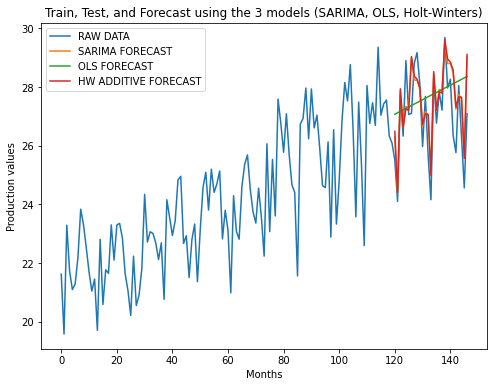

In [35]:
mu_forecast = pd.Series(mu_forecast)
mu_forecast.index = np.arange(120, 147)

# plot all model forecasts
time_df.production.plot(legend=True, label='RAW DATA', figsize=(8,6))
mu_forecast.plot(legend=True, label='SARIMA FORECAST')
y_forecast_HW_ADD.plot(legend=True, label='HW ADDITIVE FORECAST')
plt.xlabel('Months')
plt.ylabel('Production values')
plt.title('Train, Test, and Forecast using the 3 models (SARIMA, OLS, Holt-Winters)');

# SARIMAX

## Model

In [ ]:
# split the data
y_train, y_test = pm_train_test_split(pts_scaled_df['TOTAL_PTS'], train_size=season_22_ngames+season_23_ngames)

In [ ]:
# fit models
model1 = pm.auto_arima(
    y_train, 
    start_p=1, start_q=1, start_P=1, start_Q=1,
    max_p=10,   max_q=10,   max_P=10,   max_Q=10,
    max_d=10,   max_D=10,
    max_order=None,
    seasonal=True,
    m=1180, # period for season differences
    stationary=False,
    information_criterion='aic',
    stepwise=True)

sarima_residuals = model1.resid()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


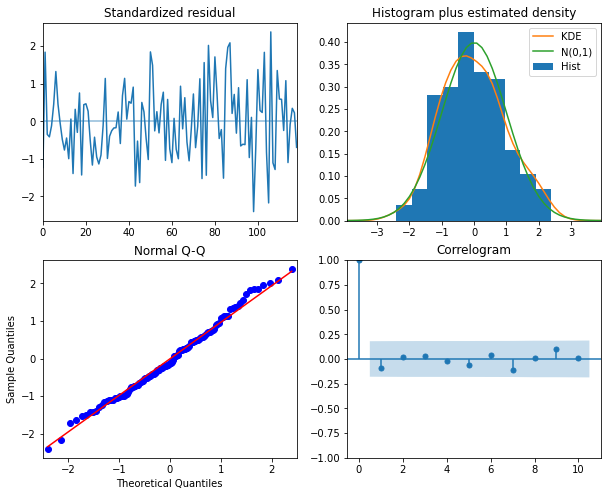

In [23]:
model1.plot_diagnostics();

## Stationarity of Residuals

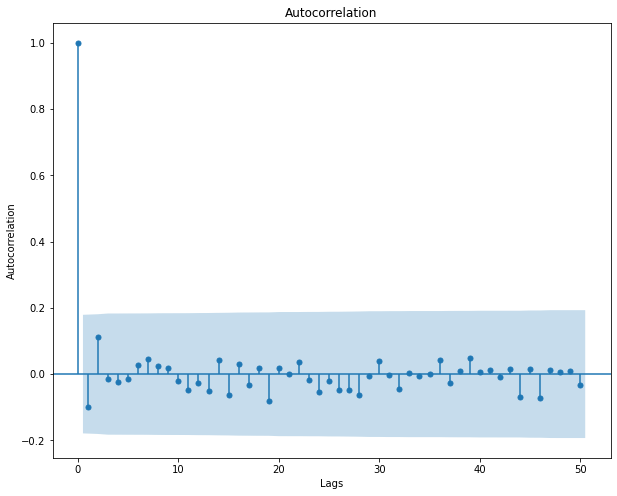

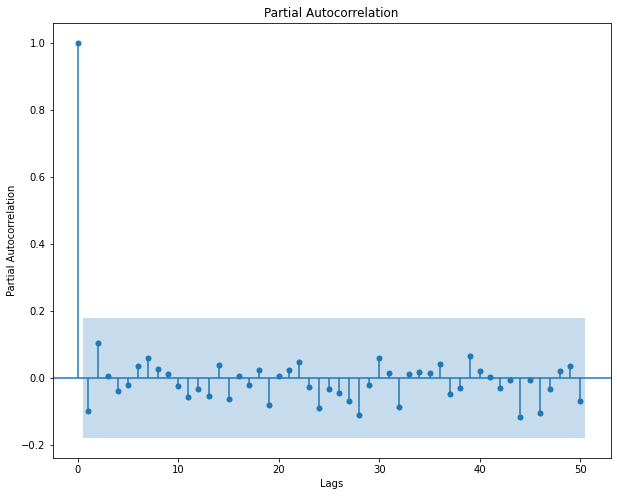

In [24]:
# plot autocorrelation and partial autocorrelation of the residuals of the series
plot_acf(sarima_residuals, lags=50);
plt.xlabel('Lags')
plt.ylabel('Autocorrelation');

plot_pacf(sarima_residuals, lags=50);
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation');

In [25]:
print("Are the model residuals stationary?")
dftest = adfuller(sarima_residuals, autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

Are the model residuals stationary?
Test statistic = -26.100
P-value = 0.000
Critical values :
	1%: -3.4865346059036564 - The data is  stationary with 99% confidence
	5%: -2.8861509858476264 - The data is  stationary with 95% confidence
	10%: -2.579896092790057 - The data is  stationary with 90% confidence


**COMMENT: The p-value for the Dickey-Fuller test is <0.05, so we can reject the null hypothesis that the data are not stationary.**

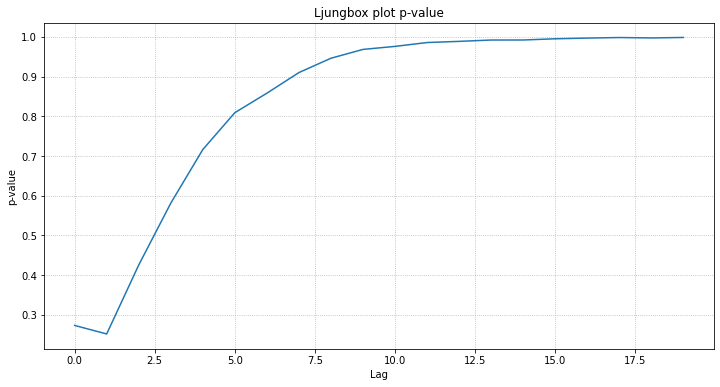

In [26]:
# Ljungbox test on model residuals

# Ljungbox plot
lj_df = sm.stats.acorr_ljungbox(sarima_residuals, lags=20, return_df=True)

# plot of time series
fig, ax = plt.subplots(figsize=(12,6))

x_axis = np.arange(lj_df.shape[0])
plt.plot(x_axis, lj_df.lb_pvalue);

ax.grid(linestyle='dotted')
ax.set(title = 'Ljungbox plot p-value', 
       xlabel = 'Lag', 
       ylabel = 'p-value');

In [27]:
# model summary
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -173.015
Date:                            Wed, 03 Nov 2021   AIC                            358.030
Time:                                    12:34:41   BIC                            374.705
Sample:                                         0   HQIC                           364.801
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.001      0.343      0.732      -0.002       0.002
ar.L1          0.2986      0.090      3.332      0.001       0.123       0.474
ma.L1         -0.9865      0.028    -35.577      0.000      -1.041      -0.932
ar.S.L12       0.9891      0.032     30.781      0.000       0.926       1.052
ma.S.L12      -0.8437      0.218     -3.877      0.000      -1.270      -0.417
sigma2         0.9632      0.182      5.282      0.000       0.606       1.321
===================================================================================
Ljung-Box (L1) (Q):                   1.10   Jarque-Bera (JB):                 1.49
Prob(Q):                              0.29   Prob(JB):                         0.47
Heteroskedasticity (H):               2.16   Skew:                             0.21
Prob(H) (two-sided):                  0.02   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""